# Bond pricing and Interest Rates in q

## Price of a zero-coupon bond

### Annually compounded

In [1]:
/
Pricing a zero coupon bond annually compounded

par - face value of the bond
y - annual yield or rate of the bond
t - time to maturity in years
\
zero_coupon_bond:{[par;y;t] par%(1+y) xexp t}

In [2]:
round:{[d;n]  ("j"$n*d) % d:xexp[10]d}
round[2] zero_coupon_bond[100;0.05;5] / price of a 5-year, $100, zero-coupon bond with yield at 5 percent, annually compounded.

78.35


### Continuously compounded

In [3]:
/
Pricing a zero coupon bond continuously compounded

The parameters are the same as before
\
zero_coupon_continuous_bond:{[par;y;t] par*exp neg y*t}

In [30]:
round[2] zero_coupon_continuous_bond[128.40;0.05;5] / price of a 5-year, $128.40, zero bond, yield 5%, continuously compounded.

100f


## Bootstrapping a yield curve

In [31]:
/
Bootstrapping a yield curve

par - bond principal ($)
T - time to maturity (years)
coup - annual coupon ($)
price - bond price ($)
freq - number of coupon payments per annum
\

data:([] par:();T:();coup:();price:();freq:())

In [32]:
/ Data from Hull, p. 106

data,:(100;0.25;0.;97.5;2)
data,:(100;0.5;0.;94.9;2)
data,:(100;1.5;8.;96.;2)
data,:(100;2.;12.;101.6;2)
data,:(100;1.;0.;90.;2)

In [33]:
data

par T    coup price freq
------------------------
100 0.25 0    97.5  2   
100 0.5  0    94.9  2   
100 1.5  8    96    2   
100 2    12   101.6 2   
100 1    0    90    2   


In [40]:
`T xasc `data / sorts the data table on T

/ Let us compute the rates of zero-coupon bonds. Coupon-bearind bonds are assigned zero.
b_z_c: select par,T,coup,price,freq,rate: ?[coup=0;(log par%price)%T;0.] from data
b_z_c

`data


par T    coup price freq rate     
----------------------------------
100 0.25 0    97.5  2    0.1012712
100 0.5  0    94.9  2    0.104693 
100 1    0    90    2    0.1053605
100 1.5  8    96    2    0        
100 2    12   101.6 2    0        


In [41]:
b_z_c_k:`T xkey b_z_c / Creating a keyed table on T

T_l:key b_z_c_k / Get the T values

i:0

/
In order to compute the rates of coupon-bearing bonds, we set a double while loop. The outer loop iterates through
each row of the table. The if statement verifies whether the instrument is coupon-bearing (those with rate presently
set to zero). The inner loop subtracts from the instrument's price the present values of the coupons. After the inner
loop is done, the command calculates the contribution of the last coupon + maturity.
\
while[i<count b_z_c_k;if[b_z_c_k[T_l[i];`rate]=0;val:b_z_c_k[T_l[i];`price];fre:b_z_c_k[T_l[i];`freq];
        pc:b_z_c_k[T_l[i];`coup]%fre;peri:T_l[i]*fre;j:0;while[j<(first peri)-1;t:(j+1)%fre;spot:b_z_c_k[t;`rate];
        val -:pc * exp neg spot * t;j+:1];b_z_c_k[T_l[i];`rate]: first neg(log(val%(b_z_c_k[T_l[i];`par]+pc)))%T_l[i]];
        i+:1]

b_z_c_k

T   | par coup price freq rate     
----| -----------------------------
0.25| 100 0    97.5  2    0.1012712
0.5 | 100 0    94.9  2    0.104693 
1   | 100 0    90    2    0.1053605
1.5 | 100 8    96    2    0.1068093
2   | 100 12   101.6 2    0.1080803


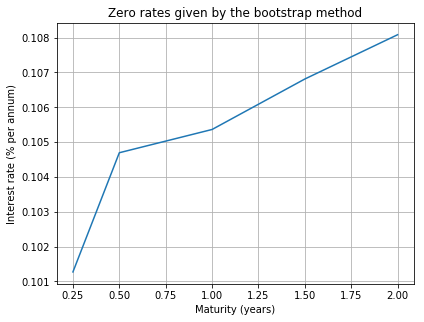

In [42]:
/ Module with wrapper for matplotlib.pyplot written in q
\l importmatplotlib.q

x:()
y:()
i:0
while[i<count key b_z_c_k; x,:first (key b_z_c_k)[i]; y,:b_z_c_k[T_l[i];`rate];i+:1]

plt:.matplotlib.pyplot[]
plt.
/\t plt:.p.module .p.import`matplotlib.pyplot
plt.plot[x;y];
plt.xlabel"Maturity (years)";
plt.ylabel"Interest rate (% per annum)";
plt.title"Zero rates given by the bootstrap method";
plt.grid 1b;
plt.show[];

## Implementing Newton-Raphson method and calculating yield to maturity

In [3]:
/
Given, as before, price, par, T, coup, freq, and aditionally an initial guess, calculate the yield to maturity.
\
bond_ytm:{[price;par;T;coup;freq;guess] per:T*freq;
            coupon:coup*par%100*freq;
            
            / coupon payment dates
            dt:(1+til floor per)%freq;
            
            / helper function is an implementation of Newton's method
            N:{[dt;coupon;par;T;price;x]f:(sum coupon*exp neg x*dt)+(par*exp neg T*x)-price;
            derf:(sum neg coupon*dt*exp neg x*dt)+neg T*par*exp neg T*x;
            x-f%derf}[dt;coupon;par;T;price;];

            / helper function is applied until default convergence
            N/[guess]}

ytm:round[2] 100*bond_ytm[98.39;100;2;6;2;0.05] / Hull example (p. 105).
ytm / YTM expressed as percentage per annum.

6.76


## Calculating the price of a bond with YTM

In [4]:
/ calculates bond price from YTM

bond_price:{[par;T;ytm;coup;freq] per:T*freq;
            coupon:coup*par%100*freq;
            / coupon payment dates
            dt:(1+til floor per)%freq;
            (sum coupon*exp neg ytm*dt)+par*exp neg ytm*T}

In [5]:
round[2] bond_price[100;2;0.0676;6;2]

98.39


## Modified duration of a bond

The modified duration of a bond can be thought of as the first derivative of the relationship between price and yield:

modified duration ≅ (P- − P+) / 2(P0)(dY) , where dy is the given change in yield, P− is the price of the bond from a decrease in yield by dy, P+ is the price of the bond from an increase in yield by dy, and P0 is the initial price of the bond (Weiming).

In [8]:
price:95.04
par:100
T:1.5
coup:5.75
freq:2
dy:0.01
guess:0.05

ytm:bond_ytm[price;par;T;coup;freq;guess]
ytm_minus:ytm-dy
price_minus:bond_price[par;T;ytm_minus;coup;freq]
ytm_plus:ytm + dy
price_plus:bond_price[par;T;ytm_plus;coup;freq]
mduration:(price_minus-price_plus)%2*price*dy
mduration / modified duration of the bond in years

1.457356


## Bond Convexity

Convexity is the sensitivity measure of the duration of a bond to yield changes (Weiming):

convexity ≅ (P− + P+ − 2P0) / (P0)(dy)^2

In [9]:
ytm:bond_ytm[price;par;T;coup;freq;guess]
ytm_minus:ytm-dy
price_minus:bond_price[par;T;ytm_minus;coup;freq]
ytm_plus:ytm + dy
price_plus:bond_price[par;T;ytm_plus;coup;freq]
convexity:(price_minus+price_plus-2*price)%price*dy xexp 2
convexity

2.157743


## Short-rate modeling with the Vasicek Model

In the one-factor Vasicek model, the short rate is modeled as a single stochastic factor (Weiming):

dr(t) = K(θ−r(t))dt + σdW(t),

where K, θ and σ are constants, and σ is the instantaneous standard deviation. W(t) is the random Wiener process.

In [18]:
/
Function to compute normally distributed random numbers (copied from <http://kx.com/q/stat.q>)
\

pi:acos -1

/ normal from x
nx:{abs(x>0)-(exp[-.5*x*x]%sqrt 2*pi)*t*.31938153+t*-.356563782+t*1.781477937+t*-1.821255978+1.330274429*t:1%1+.2316419*abs x}

/ x from normal  (chebychev near 0.5 and log for the tails)
xn:{$[.5>x;0-.z.s 1-x;.92>x;
 (x*2.50662823884+l*-18.61500062529+l*41.39119773534+l*-25.44106049637)%1+l*-8.47351093090+l*23.08336743743+l*-21.06224101826+3.13082909833*l:x*x-:.5;
 0.3374754822726147+l*0.9761690190917186+l*0.1607979714918209+l*0.0276438810333863+l*0.0038405729373609+l*0.0003951896511919+l*0.0000321767881768+l*0.0000002888167364+0.0000003960315187*l:log 0-log 1-x]}

/ random normal distribution, e.g. nor 10
nor:{$[x=2*n:x div 2;raze sqrt[-2*log n?1f]*/:(sin;cos)@\:(2*pi)*n?1f;-1_.z.s 1+x]}


In [46]:
r0:0.01875
K:0.20
theta:0.01
sigma:0.012
T:10.
N:100

dt:T%N
rates:enlist r0
i:0

while[i<N;
        / computes the step length
        dr:K*dt*(theta-last rates)+sigma*first nor 1;
        / saves the rate's computed value
        rates,:last rates+dr;
        / advances to the next point
        i+:1]



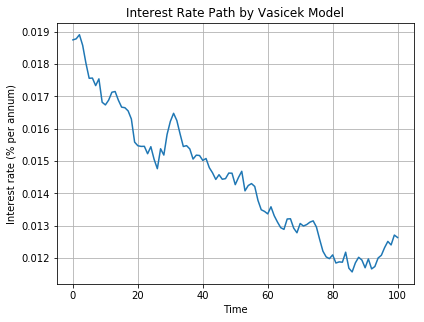

In [47]:
/ Module with wrapper for matplotlib.pyplot written in q
\l importmatplotlib.q

plt:.matplotlib.pyplot[]
plt.
/\t plt:.p.module .p.import`matplotlib.pyplot

x:til N+1
y:rates

plt.plot[x;y];
plt.xlabel"Time";
plt.ylabel"Interest rate (% per annum)";
plt.title"Interest Rate Path by Vasicek Model";
plt.grid 1b;
plt.show[];